In [1]:
## Word 2 Vec с нуля

In [2]:
### Домашнее задание
# 1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
# 2. Обучить word2vec на фразах персонажей
# 3. Визуаилизировать embeddings по самым частотным словам (top 1000)
# 4. Найти самые близкие слова для:
#  homer - marge + bart
#  bart - lisa + school
#  marge - homer + home
# 5* попробовать построить классификатор bart/lisa с использованием этих эмбеддингов

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
import numpy as np
from nltk.tokenize import word_tokenize

In [2]:
import csv
a = []
with open('../../study_data/DL_13_HW/simpsons_script_lines.csv', newline='\n') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        a.append(row)

In [3]:
len(a)

158272

In [4]:
columns = []
for i in range(pd.DataFrame(a[1:]).shape[1]):
    try:
        if a[0][i] != '':
            columns.append(a[0][i])
    except:
        columns.append('c'+str(i))

In [5]:
df = pd.DataFrame(a[1:], columns = columns)

In [6]:
df = df[df['c13'].isnull()][['id',
 'episode_id',
 'number',
 'raw_text',
 'timestamp_in_ms',
 'speaking_line',
 'character_id',
 'location_id',
 'raw_character_text',
 'raw_location_text',
 'spoken_words',
 'normalized_text',
 'word_count']]
df = df[~(df['normalized_text'].isnull())]

In [7]:
df.shape

(158247, 13)

In [8]:
df.head(2)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3


In [9]:
### почистили немного датасет - просто по pd.read_csv не открывался. Удалили менее 30 строк.
### выучим теперь по тексту Word2Vec - посмотрим на качество

In [10]:
phrases = df['normalized_text'].tolist()

In [11]:
text = ' '.join(phrases)

In [12]:
text = text[:100000]

In [13]:
len(text)

100000

In [14]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = text.split()

split_ind = (int)(len(text) * 0.8)

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 3399


In [15]:
# context window size is two
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]]
        target = text[i]
        data.append((context, target))
    return data

def create_skipgram_dataset(text):
    import random
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        # negative sampling
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0))
    return data

cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
print('skipgram sample', skipgram_train[0])

cbow sample (['no', 'actually', 'was', 'a'], 'it')
skipgram sample ('it', 'no', 1)


In [16]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_ctx = self.embeddings(context).view((1, -1))
        score = torch.mm(embed_focus, torch.t(embed_ctx))
        log_probs = F.logsigmoid(score)
    
        return log_probs

In [22]:
embd_size = 50
learning_rate = 0.001
n_epoch = 3

def train_cbow():
    hidden_size = 64
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size).to(device)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = torch.LongTensor(ctx_idxs).to(device)

            model.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, torch.LongTensor([w2i[target]]).to(device))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print('Epoch: ', epoch, '  Total loss: ', total_loss)    
        losses.append(total_loss)
    return model, losses

def train_skipgram():
    losses = []
    loss_fn = nn.MSELoss()
    model = SkipGram(vocab_size, embd_size).to(device)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w, target in skipgram_train:
            in_w_var = torch.LongTensor([w2i[in_w]]).to(device)
            out_w_var = torch.LongTensor([w2i[out_w]]).to(device)
            
            model.zero_grad()
            log_probs = model(in_w_var, out_w_var)
            loss = loss_fn(log_probs[0], torch.Tensor([target]).to(device))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print('Epoch: ', epoch, '  Total loss: ', total_loss)    
        losses.append(total_loss)
    return model, losses

In [20]:
cbow_model, cbow_losses = train_cbow()

CBOW(
  (embeddings): Embedding(3399, 50)
  (linear1): Linear(in_features=200, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=3399, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch:  0   Total loss:  154587.40085935593
Epoch:  1   Total loss:  138479.3023633957
Epoch:  2   Total loss:  129449.5727648735


In [29]:
n_epoch = 3
learning_rate = 0.01

sg_model, sg_losses = train_skipgram()

SkipGram(
  (embeddings): Embedding(3399, 50)
)
Epoch:  0   Total loss:  645501.3659632446
Epoch:  1   Total loss:  93329.18023286185
Epoch:  2   Total loss:  83679.19529378969


In [62]:
n_epoch = 3
learning_rate = 0.005

optimizer = optim.SGD(sg_model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(n_epoch):
    total_loss = .0
    for in_w, out_w, target in skipgram_train:
        in_w_var = torch.LongTensor([w2i[in_w]]).to(device)
        out_w_var = torch.LongTensor([w2i[out_w]]).to(device)
            
        sg_model.zero_grad()
        log_probs = sg_model(in_w_var, out_w_var)
        loss = loss_fn(log_probs[0], torch.Tensor([target]).to(device))
            
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print('Epoch: ', epoch, '  Total loss: ', total_loss)    
    sg_losses.append(total_loss)

Epoch:  0   Total loss:  81824.73999353107
Epoch:  1   Total loss:  81210.28969098946
Epoch:  2   Total loss:  80831.89201115599


In [ ]:
n_epoch = 7
learning_rate = 0.0001
loss_fn = nn.MSELoss()

optimizer = optim.Adam(sg_model.parameters(), lr=learning_rate)
    
for epoch in range(n_epoch):
    total_loss = .0
    for in_w, out_w, target in skipgram_train:
        in_w_var = torch.LongTensor([w2i[in_w]]).to(device)
        out_w_var = torch.LongTensor([w2i[out_w]]).to(device)
            
        sg_model.zero_grad()
        log_probs = sg_model(in_w_var, out_w_var)
        loss = loss_fn(log_probs[0], torch.Tensor([target]).to(device))
            
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print('Epoch: ', epoch, '  Total loss: ', total_loss)    
    sg_losses.append(total_loss)

In [64]:
skip = [sg_model, sg_losses]

In [65]:
import pickle
with open('sg_model.pkl', 'wb') as f:
    pickle.dump(skip, f)

In [66]:
with open('sg_model.pkl', 'rb') as f:
    skip= pickle.load(f)
sg_model, sg_losses = skip

In [67]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = torch.LongTensor(ctx_idxs).to(device)

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted.item()]
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, out_w, target in test_data:
        in_w_var = torch.LongTensor([w2i[in_w]]).to(device)
        out_w_var = torch.LongTensor([w2i[out_w]]).to(device)

        model.zero_grad()
        log_probs = model(in_w_var, out_w_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted = predicted.item()
        if predicted == target:
            correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_cbow(cbow_train, cbow_model)
print('------')
test_skipgram(skipgram_train, sg_model)

====Test CBOW===


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Accuracy: 7.7% (1526/19728)
------
====Test SkipGram===
Accuracy: 50.0% (78912/157824)


In [68]:
embed = sg_model.embeddings

In [69]:
embed_dict = {}

for i in zip(vocab, embed.weight.data.cpu().numpy()):
    embed_dict[i[0]] = i[1]

In [ ]:
#homer - marge + bart

In [83]:
first = embed_dict['homer'] - embed_dict['marge'] + embed_dict['bart']

In [84]:
from scipy.spatial import distance

m = 100000
v = ''
for i in zip(vocab, embed.weight.data.cpu().numpy()):
    if distance.cosine(first, i[1]) < m:
        m = distance.cosine(first, i[1])
        v = i[0]
print('Самое близкое слово к homer - marge + bart: ', v)

Самое близкое слово к homer - marge + bart:  homer


In [85]:
#bart - lisa + school

In [86]:
second = embed_dict['bart'] - embed_dict['lisa'] + embed_dict['school']
m = 100000
v = ''
for i in zip(vocab, embed.weight.data.cpu().numpy()):
    if distance.cosine(second, i[1]) < m:
        m = distance.cosine(first, i[1])
        v = i[0]
print('Самое близкое слово к bart - lisa + school: ', v)

Самое близкое слово к bart - lisa + school:  as


In [87]:
#marge - homer + home

In [88]:
third = embed_dict['marge'] - embed_dict['homer'] + embed_dict['home']
m = 100000
v = ''
for i in zip(vocab, embed.weight.data.cpu().numpy()):
    if distance.cosine(third, i[1]) < m:
        m = distance.cosine(first, i[1])
        v = i[0]
print('Самое близкое слово к marge - homer + home: ', v)

Самое близкое слово к marge - homer + home:  dad


In [115]:
### Визуализируем top 1000 слов

In [93]:
from collections import Counter

In [97]:
c = Counter(text = ' '.join(phrases).split())
top1000 = c.most_common(1000)

In [104]:
top1000 = top1000[0][1]

In [108]:
X = []
voc = []
for i in zip(vocab, embed.weight.data.cpu().numpy()):
    if i[0] in top1000:
        X.append(i[1])
        voc.append(i[0])

In [111]:
X = np.array(X)

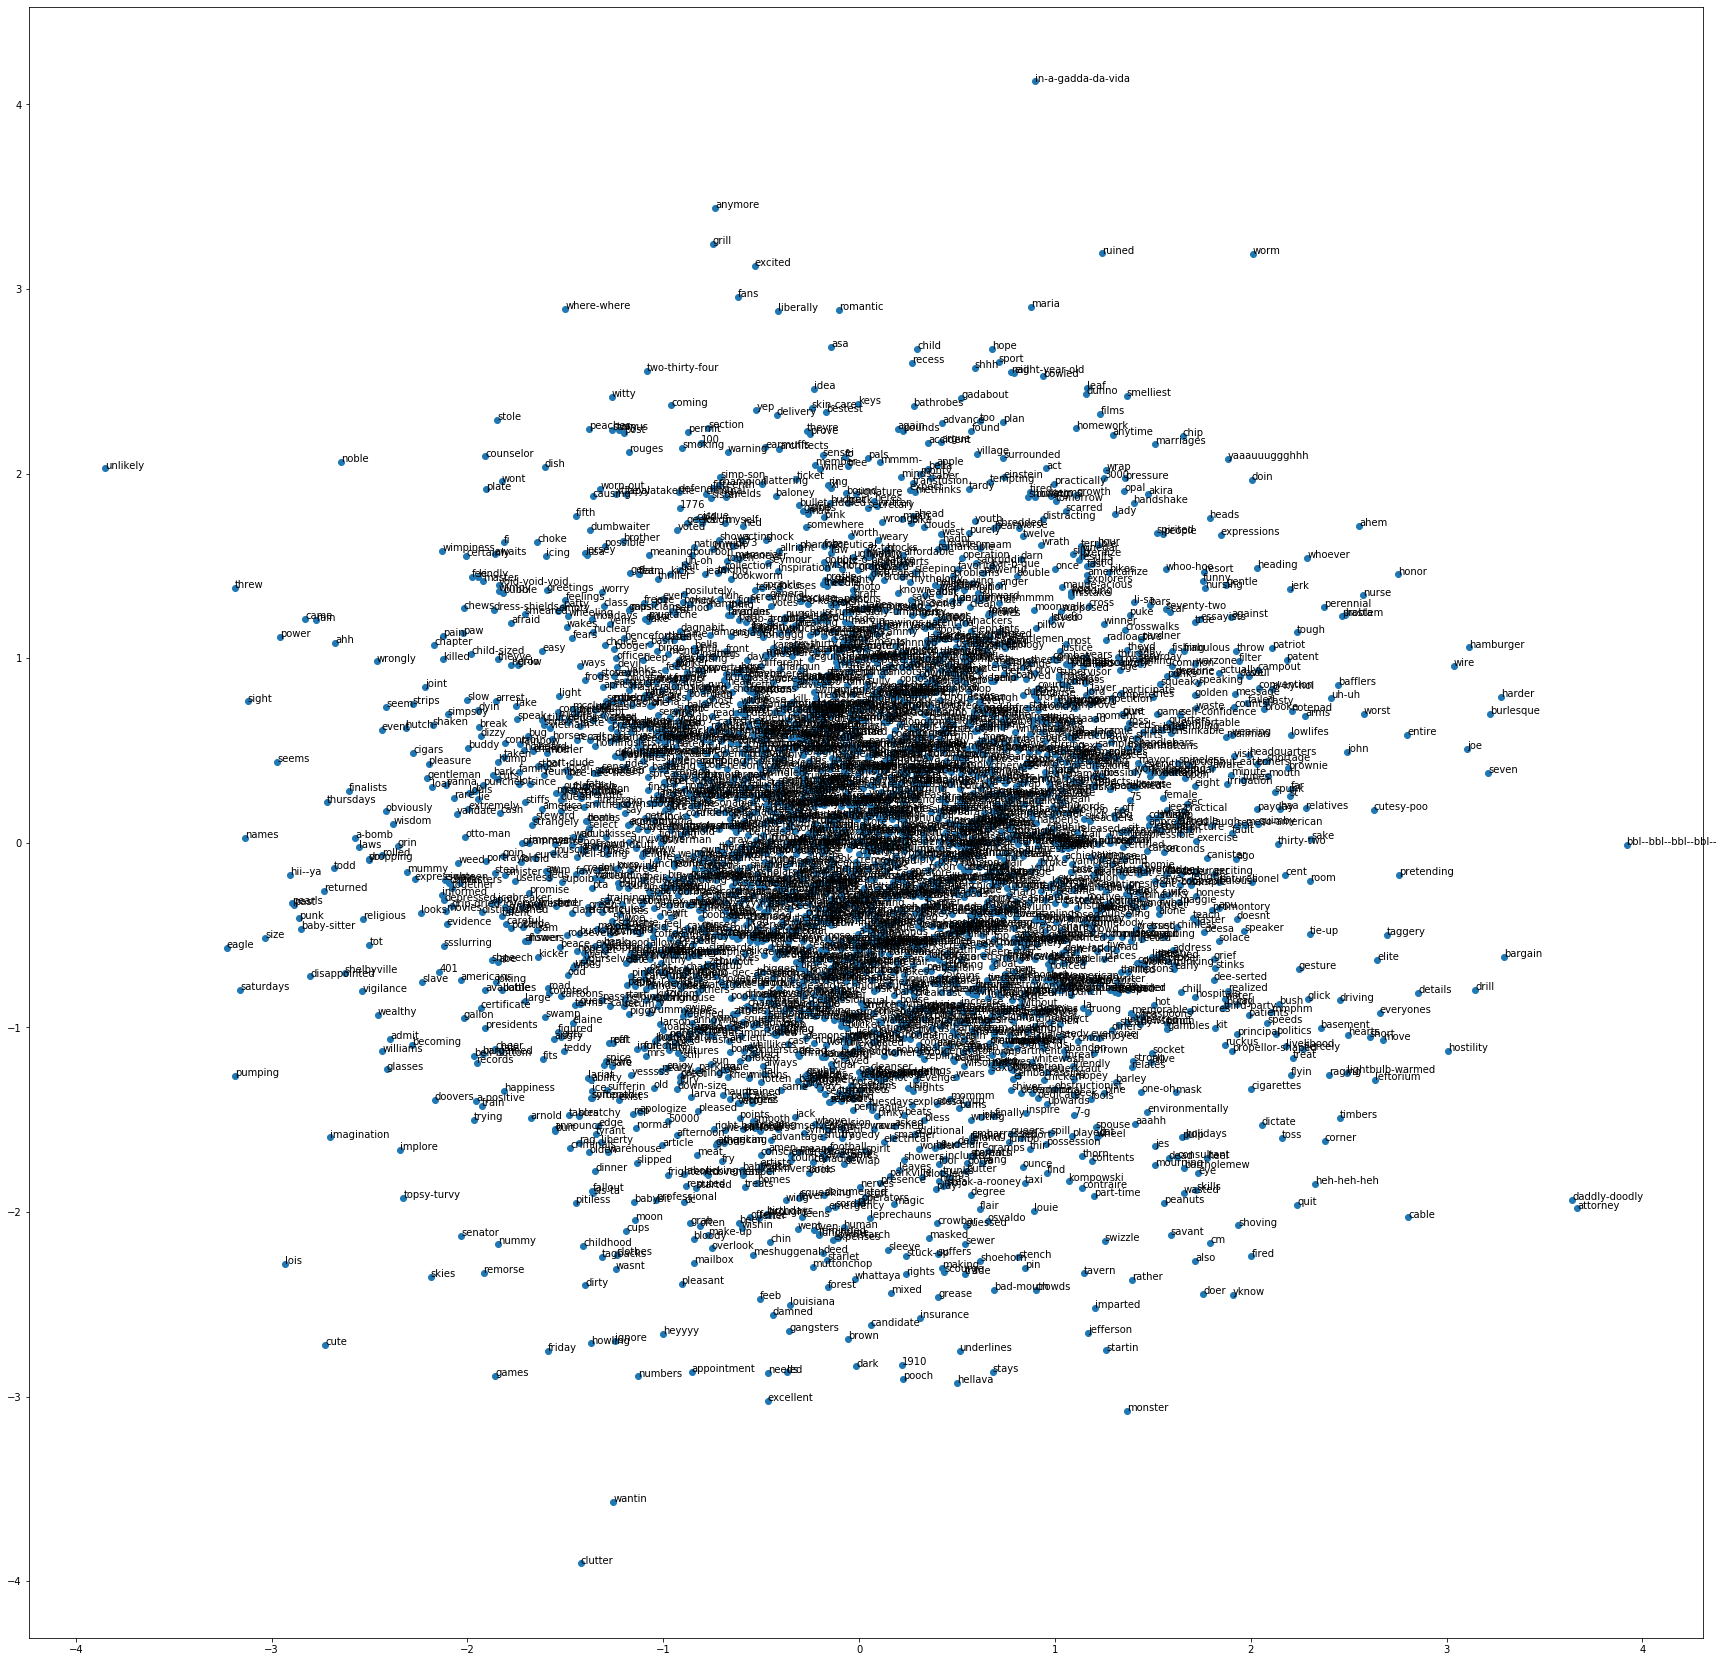

In [114]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize = (30,30))
plt.scatter(result[:, 0], result[:, 1])
words = voc
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

<Figure size 432x288 with 0 Axes>

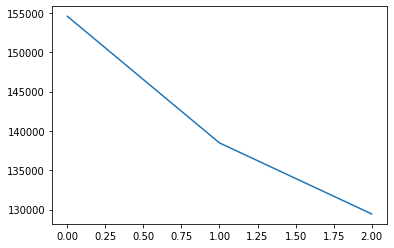

<Figure size 432x288 with 0 Axes>

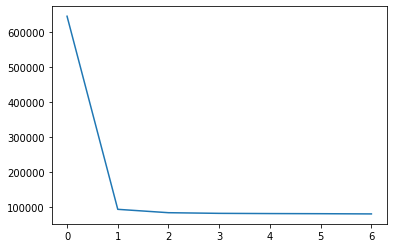

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')
showPlot(sg_losses, 'SkipGram Losses')

#### Дальше просьба не смотреть - была попытка реализовать NEGATIVE SAMPLING

In [ ]:
## GenSim с нуля

In [ ]:
from gensim.models import Word2Vec
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)


In [ ]:
X = model[model.wv.vocab]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [ ]:
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [ ]:
## Gensim готовый

In [ ]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

In [ ]:
mother 2398 329 4234 485 73485 


In [ ]:
from gensim.models import KeyedVectors
# load the google word2vec model
filename = 'GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)
print(result)

In [ ]:
## Домашнее задание
1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Визуаилизировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для:
  homer - marge + bart
  bart - lisa + school
  marge - homer + home
5* попробовать построить классификатор bart/lisa с использованием этих эмбеддингов

In [ ]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 2
NUM_EPOCHS = 5
NEGATIVE_SAMPLING = True

def gather_word_freqs(split_text, subsampling = False, sampling_rate = 0.001):
    vocab = {}
    ix_to_word = {}
    word_to_ix = {}
    total = 0.0
    for word in split_text:
        if word not in vocab:
            vocab[word] = 0
            ix_to_word[len(word_to_ix)] = word
            word_to_ix[word] = len(word_to_ix)
        vocab[word] += 1.0
        total += 1.0
    if subsampling:
        for i, word in enumerate(split_text):
            val = np.sqrt(sampling_rate * total / vocab[word])
            prob = val * (1 + val)
            sampling = np.random.sample()
            if (sampling <= prob):
                del [split_text[i]]
                i -= 1
    return split_text, vocab, word_to_ix, ix_to_word

def gather_training_data(split_text, word_to_ix, context_size, model_type = "skipgram"):
    training_data = []
    for i, word in enumerate(split_text):
        if (model_type == "skipgram"):
            back_i = i - 1
            back_c = 0
            forw_i = i + 1
            forw_c = 0
            while (back_i >= 0 and back_c < context_size):
                training_data.append(([word_to_ix[word]], word_to_ix[split_text[back_i]]))
                back_i -= 1
                back_c += 1
            while (forw_i < len(split_text) and forw_c < context_size):
                training_data.append(([word_to_ix[word]], word_to_ix[split_text[forw_i]]))
                forw_i += 1
                forw_c += 1
        elif (model_type == "cbow"):
            point = []
            back_i = i - 1
            back_c = 0
            forw_i = i + 1
            forw_c = 0
            while (back_i >= 0 and back_c < context_size):
                point.append(word_to_ix[split_text[back_i]])
                back_i -= 1
                back_c += 1
            while (forw_i < len(split_text) and forw_c < context_size):
                point.append(word_to_ix[split_text[forw_i]])
                forw_i += 1
                forw_c += 1
            training_data.append((point, word_to_ix[word]))
        else:
            raise ValueError("Inappropriate argument value for model_type - either `skipgram` or `cbow`.")
    return training_data

def load_data(text, context_size, model_type = "skipgram", subsampling = False, sampling_rate = 0.001):
        processed_text = word_tokenize(text)
        processed_text, vocab, word_to_ix, ix_to_word = gather_word_freqs(processed_text,
            subsampling = subsampling, sampling_rate = sampling_rate)
        training_data = gather_training_data(processed_text, word_to_ix, context_size,
                                             model_type = model_type)
        return processed_text, vocab, word_to_ix, ix_to_word, training_data

In [ ]:
processed_text, vocab, word_to_ix, ix_to_word, training_data = load_data(text,
                                                                         CONTEXT_SIZE, model_type="skipgram", subsampling=True, sampling_rate=0.001)

In [ ]:
class NEGLoss(nn.Module):
    def __init__(self, ix_to_word, word_freqs, num_negative_samples=5,):
        super(NEGLoss, self).__init__()
        self.num_negative_samples = num_negative_samples
        self.num_words = len(ix_to_word)
        self.distr = F.normalize(torch.Tensor(
            [word_freqs[ix_to_word[i]] for i in range(len(word_freqs))]).pow(0.75), dim=0
        )

    def sample(self, num_samples, positives=[]):
        weights = torch.zeros((self.num_words, 1))
        for w in positives: weights[w] += 1.0
        for _ in range(num_samples):
            w = torch.multinomial(self.distr, 1)[0]
            while (w in positives):
                w = torch.multinomial(self.distr, 1)[0]
            weights[w] += 1.0
        return weights

    def forward(self, input, target):
        return F.nll_loss(input, target,
            self.sample(self.num_negative_samples, positives=target.data.numpy()))